# Predicting Extreme Energy Poverty Using Satellite Embeddings

This notebook demonstrates how to use Random Forest regression to predict **extreme energy poverty rate** (`sdg1_1_eepr`) - the percentage of houses in extreme energy poverty (2016) - using 64-dimensional satellite imagery embeddings from Google Earth Engine.

## Why This Variable?
- **Direct measurement**: Percentage of houses in extreme energy poverty, not a composite index
- **Policy relevant**: Directly actionable for electrification programs
- **Clear interpretation**: Easy to understand and communicate

## Objectives
1. Load and merge SDG variables with satellite embeddings
2. Build a Random Forest model with cross-validation
3. Analyze feature importance
4. Evaluate model performance
5. Identify municipalities with highest energy poverty
6. Visualize predictions spatially

## 1. Setup and Data Loading

In [1]:
# Install required packages (uncomment if needed)
# !pip install pandas numpy scikit-learn matplotlib seaborn geopandas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
# Define repository URL
REPO_URL = "https://raw.githubusercontent.com/quarcs-lab/ds4bolivia/master"

# Load datasets
print("Loading datasets...")
url_names = f"{REPO_URL}/regionNames/regionNames.csv"
url_sdg_vars = f"{REPO_URL}/sdgVariables/sdgVariables.csv"
url_embeddings = f"{REPO_URL}/satelliteEmbeddings/satelliteEmbeddings2017.csv"

df_names = pd.read_csv(url_names)
df_sdg_vars = pd.read_csv(url_sdg_vars)
df_embeddings = pd.read_csv(url_embeddings)

print(f"✓ Loaded {len(df_names)} municipalities")
print(f"✓ Loaded {len(df_sdg_vars.columns)-1} SDG variables")
print(f"✓ Loaded {len(df_embeddings.columns)-1} satellite embedding dimensions")

Loading datasets...
✓ Loaded 339 municipalities
✓ Loaded 64 SDG variables
✓ Loaded 64 satellite embedding dimensions


## 2. Data Preparation

In [4]:
# Merge datasets
df = pd.merge(df_names, df_sdg_vars, on='asdf_id', how='inner')
df = pd.merge(df, df_embeddings, on='asdf_id', how='inner')

print(f"Merged dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df[['mun', 'dep', 'sdg1_1_eepr', 'A00', 'A01', 'A02']].head()

Merged dataset shape: (339, 136)

First few rows:


,mun,dep,sdg1_1_eepr,A00,A01,A02
0,Esmeralda,Oruro,NaN,-0.060433,-0.052295,-0.009320
1,Quillacas,Oruro,88.300003,-0.104140,0.013027,-0.063797
2,Pampa Aullagas,Oruro,96.699997,-0.107063,0.021826,-0.036949
3,Llallagua,Potosí,53.299999,-0.130482,-0.044621,-0.114217
4,Caripuyo,Potosí,84.199997,-0.123298,-0.058626,-0.108308


In [5]:
# Target variable and related indicators
target_var = 'sdg1_1_eepr'  # Extreme energy poverty rate
related_vars = ['sdg1_1_ubn', 'sdg1_2_mpi', 'sdg7_1_ec']  # Related poverty measures

print(f"Target variable: {target_var}")
print(f"Definition: Extreme energy poverty rate, 2016 (% of houses)")
print(f"\nMissing values in target: {df[target_var].isna().sum()} municipalities")

Target variable: sdg1_1_eepr
Definition: Extreme energy poverty rate, 2016 (% of houses)

Missing values in target: 24 municipalities


In [6]:
# Remove rows with missing data
embedding_cols = [col for col in df.columns if col.startswith('A')]
df_clean = df[['asdf_id', 'mun', 'dep', target_var] + related_vars + embedding_cols].dropna()

print(f"Clean dataset shape: {df_clean.shape}")
print(f"Municipalities with complete data: {len(df_clean)}")
print(f"Number of embedding features: {len(embedding_cols)}")

Clean dataset shape: (315, 71)
Municipalities with complete data: 315
Number of embedding features: 64


In [7]:
# Prepare features (X) and target (y)
X = df_clean[embedding_cols].values
y = df_clean[target_var].values

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget variable statistics (% of houses in extreme energy poverty):")
print(f"Mean: {y.mean():.2f}%")
print(f"Median: {np.median(y):.2f}%")
print(f"Std: {y.std():.2f}%")
print(f"Min: {y.min():.2f}%")
print(f"Max: {y.max():.2f}%")

Features shape: (315, 64)
Target shape: (315,)

Target variable statistics (% of houses in extreme energy poverty):
Mean: 62.26%
Median: 66.40%
Std: 22.97%
Min: 10.60%
Max: 97.70%


## 3. Exploratory Analysis

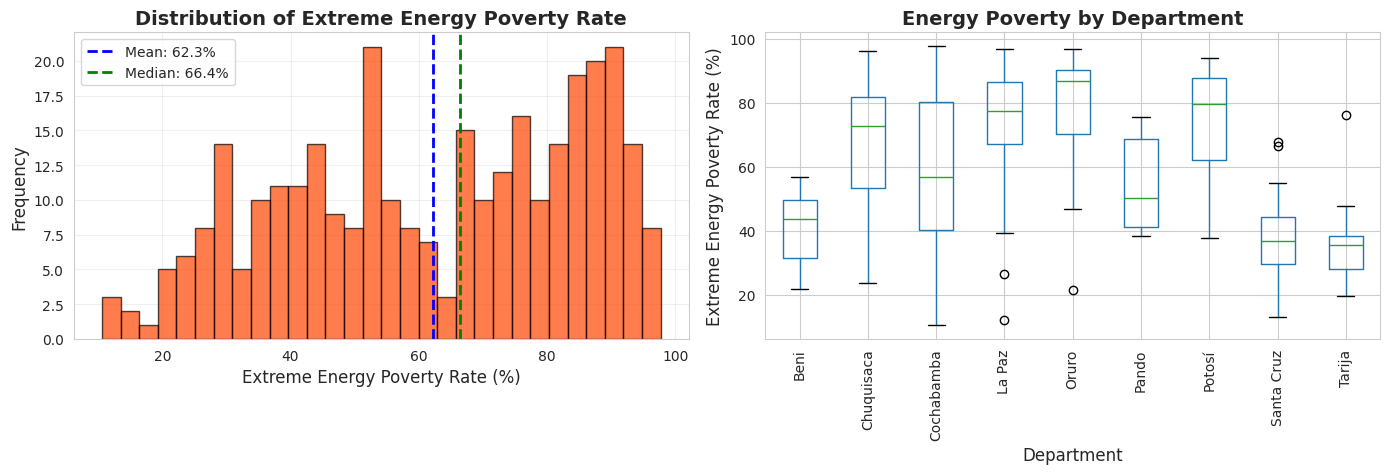


Note: Higher values = MORE houses in extreme energy poverty


In [8]:
# Distribution of extreme energy poverty rate
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(y, bins=30, edgecolor='black', alpha=0.7, color='orangered')
axes[0].axvline(y.mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean: {y.mean():.1f}%')
axes[0].axvline(np.median(y), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(y):.1f}%')
axes[0].set_xlabel('Extreme Energy Poverty Rate (%)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Extreme Energy Poverty Rate', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot by department
df_clean.boxplot(column=target_var, by='dep', ax=axes[1], rot=90)
axes[1].set_xlabel('Department', fontsize=12)
axes[1].set_ylabel('Extreme Energy Poverty Rate (%)', fontsize=12)
axes[1].set_title('Energy Poverty by Department', fontsize=14, fontweight='bold')
plt.suptitle('')  # Remove automatic title

plt.tight_layout()
plt.show()

print(f"\nNote: Higher values = MORE houses in extreme energy poverty")

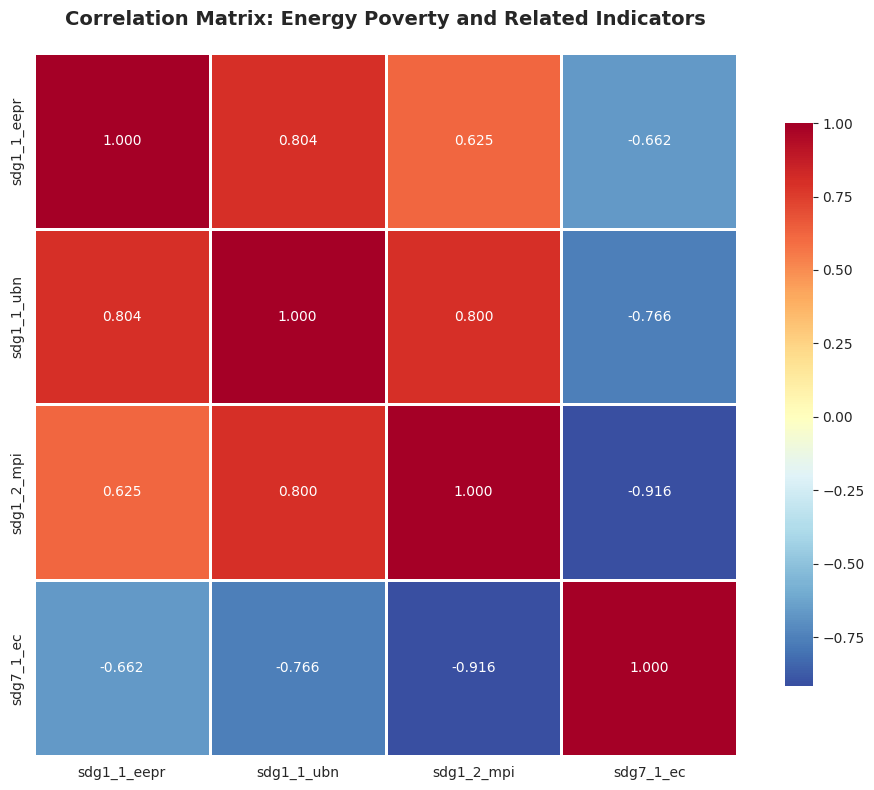


Variable Descriptions:
  sdg1_1_eepr: Extreme energy poverty rate (%)
  sdg1_1_ubn:  Unsatisfied basic needs (%)
  sdg1_2_mpi:  Multidimensional poverty index
  sdg7_1_ec:   Electricity coverage (%) - negative correlation expected


In [9]:
# Correlation with related poverty indicators
corr_vars = [target_var] + related_vars
corr_matrix = df_clean[corr_vars].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdYlBu_r',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Energy Poverty and Related Indicators', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nVariable Descriptions:")
print("  sdg1_1_eepr: Extreme energy poverty rate (%)")
print("  sdg1_1_ubn:  Unsatisfied basic needs (%)")
print("  sdg1_2_mpi:  Multidimensional poverty index")
print("  sdg7_1_ec:   Electricity coverage (%) - negative correlation expected")

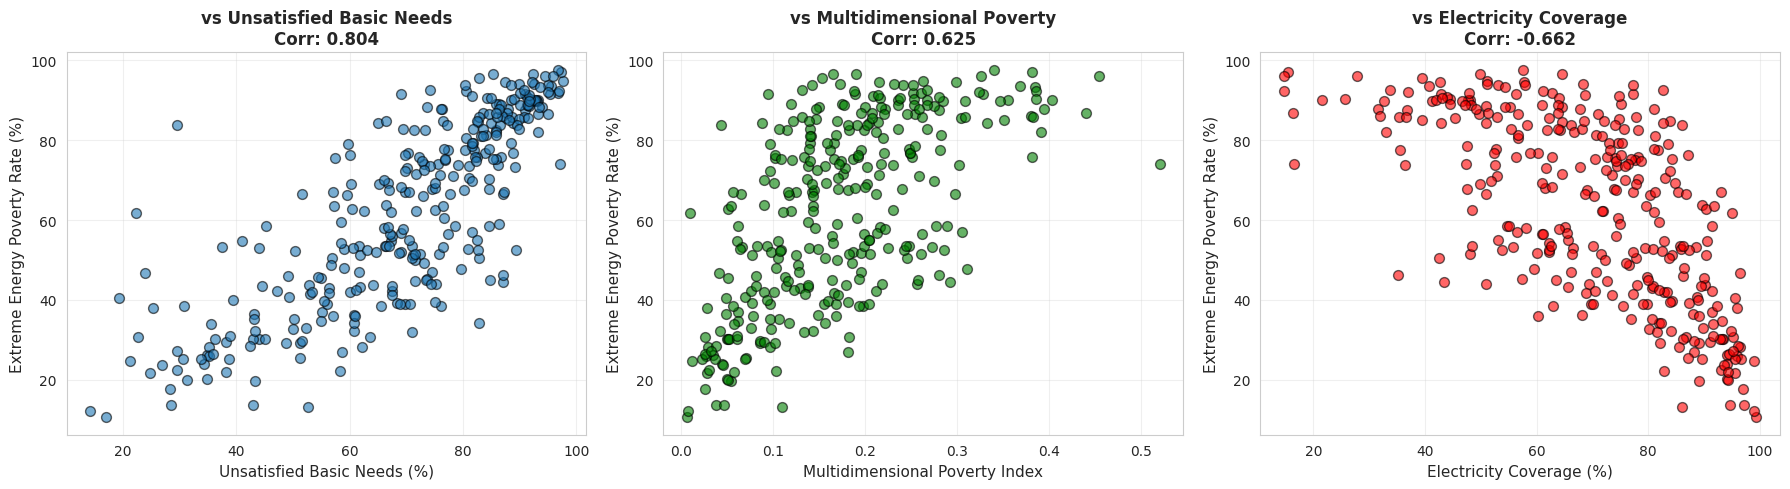

In [10]:
# Scatter plots with related indicators
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# vs Unsatisfied Basic Needs
axes[0].scatter(df_clean['sdg1_1_ubn'], df_clean[target_var],
                alpha=0.6, edgecolor='black', s=50)
axes[0].set_xlabel('Unsatisfied Basic Needs (%)', fontsize=11)
axes[0].set_ylabel('Extreme Energy Poverty Rate (%)', fontsize=11)
corr_ubn = df_clean[[target_var, 'sdg1_1_ubn']].corr().iloc[0, 1]
axes[0].set_title(f'vs Unsatisfied Basic Needs\nCorr: {corr_ubn:.3f}', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# vs Multidimensional Poverty
axes[1].scatter(df_clean['sdg1_2_mpi'], df_clean[target_var],
                alpha=0.6, edgecolor='black', s=50, color='green')
axes[1].set_xlabel('Multidimensional Poverty Index', fontsize=11)
axes[1].set_ylabel('Extreme Energy Poverty Rate (%)', fontsize=11)
corr_mpi = df_clean[[target_var, 'sdg1_2_mpi']].corr().iloc[0, 1]
axes[1].set_title(f'vs Multidimensional Poverty\nCorr: {corr_mpi:.3f}', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

# vs Electricity Coverage (negative expected)
axes[2].scatter(df_clean['sdg7_1_ec'], df_clean[target_var],
                alpha=0.6, edgecolor='black', s=50, color='red')
axes[2].set_xlabel('Electricity Coverage (%)', fontsize=11)
axes[2].set_ylabel('Extreme Energy Poverty Rate (%)', fontsize=11)
corr_ec = df_clean[[target_var, 'sdg7_1_ec']].corr().iloc[0, 1]
axes[2].set_title(f'vs Electricity Coverage\nCorr: {corr_ec:.3f}', fontsize=12, fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Model Training with Cross-Validation

In [11]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 252
Test set size: 63


In [12]:
# Initialize Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

print("Model Configuration:")
print(f"  - n_estimators: {rf_model.n_estimators}")
print(f"  - max_depth: {rf_model.max_depth}")
print(f"  - min_samples_split: {rf_model.min_samples_split}")
print(f"  - min_samples_leaf: {rf_model.min_samples_leaf}")
print(f"  - max_features: {rf_model.max_features}")

Model Configuration:
  - n_estimators: 500
  - max_depth: 10
  - min_samples_split: 5
  - min_samples_leaf: 2
  - max_features: sqrt


In [13]:
# Perform 5-fold cross-validation on training set
print("\nPerforming 5-fold cross-validation...")
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores_r2 = cross_val_score(rf_model, X_train, y_train, cv=kfold, scoring='r2', n_jobs=-1)
cv_scores_mse = -cross_val_score(rf_model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1)
cv_scores_mae = -cross_val_score(rf_model, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error', n_jobs=-1)

print("\n📊 Cross-Validation Results (5-Fold):")
print(f"  R² Score:  {cv_scores_r2.mean():.4f} (±{cv_scores_r2.std():.4f})")
print(f"  RMSE:      {np.sqrt(cv_scores_mse.mean()):.4f} (±{np.sqrt(cv_scores_mse.std()):.4f})")
print(f"  MAE:       {cv_scores_mae.mean():.4f} (±{cv_scores_mae.std():.4f})")


Performing 5-fold cross-validation...

📊 Cross-Validation Results (5-Fold):
  R² Score:  0.5704 (±0.0823)
  RMSE:      14.8721 (±7.4486)
  MAE:       11.5312 (±1.5173)


In [14]:
# Train final model on full training set
print("\nTraining final model on full training set...")
rf_model.fit(X_train, y_train)
print("✓ Model training complete!")


Training final model on full training set...
✓ Model training complete!


## 5. Model Evaluation

In [15]:
# Make predictions
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("\n🎯 Model Performance:")
print("\nTraining Set:")
print(f"  R² Score:  {train_r2:.4f}")
print(f"  RMSE:      {train_rmse:.4f}%")
print(f"  MAE:       {train_mae:.4f}%")

print("\nTest Set:")
print(f"  R² Score:  {test_r2:.4f}")
print(f"  RMSE:      {test_rmse:.4f}%")
print(f"  MAE:       {test_mae:.4f}%")

print(f"\nOverfitting Check:")
print(f"  R² Difference: {train_r2 - test_r2:.4f}")
if (train_r2 - test_r2) < 0.1:
    print("  ✓ Model shows good generalization")
else:
    print("  ⚠ Model may be overfitting")

print(f"\n  Real-World Interpretation:")
print(f"    Average prediction error: ±{test_mae:.1f} percentage points")
print(f"    Example: If actual is 70%, model predicts 70±{test_mae:.1f}%")


🎯 Model Performance:

Training Set:
  R² Score:  0.9070
  RMSE:      6.8898%
  MAE:       5.2877%

Test Set:
  R² Score:  0.2216
  RMSE:      21.5127%
  MAE:       15.5189%

Overfitting Check:
  R² Difference: 0.6854
  ⚠ Model may be overfitting

  Real-World Interpretation:
    Average prediction error: ±15.5 percentage points
    Example: If actual is 70%, model predicts 70±15.5%


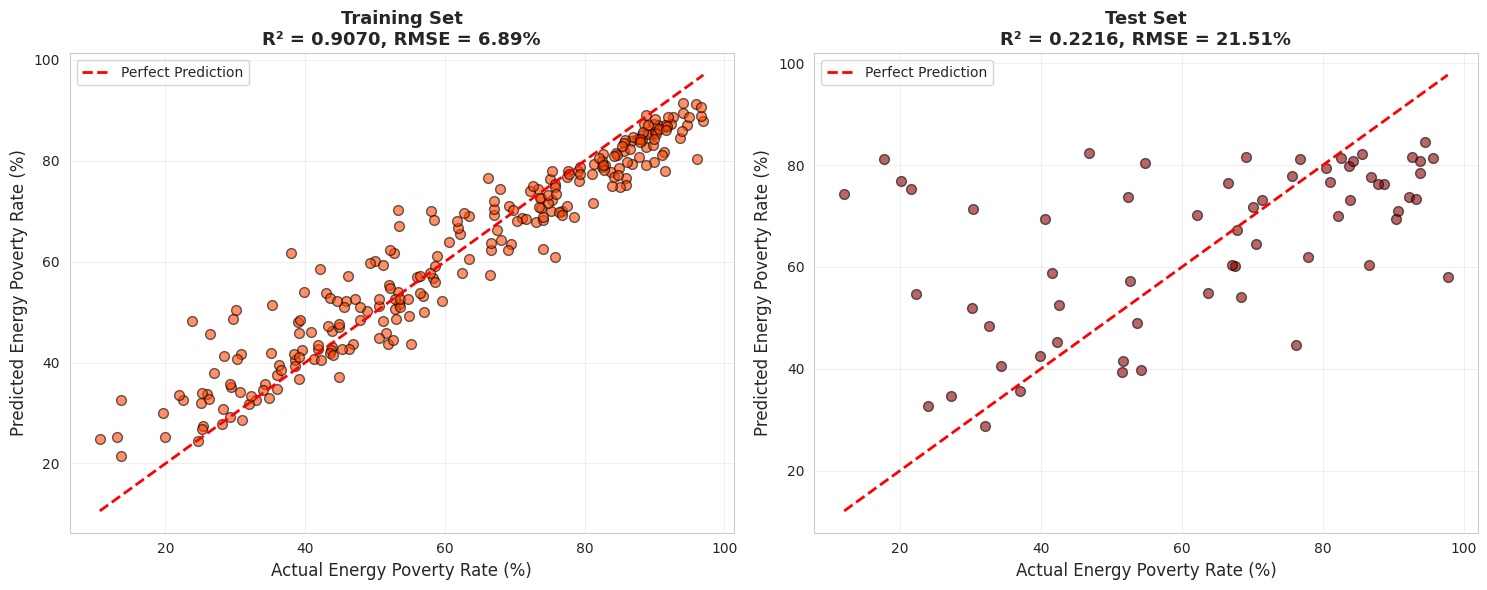

In [16]:
# Predicted vs Actual plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Training set
axes[0].scatter(y_train, y_train_pred, alpha=0.6, edgecolor='black', s=50, color='orangered')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Energy Poverty Rate (%)', fontsize=12)
axes[0].set_ylabel('Predicted Energy Poverty Rate (%)', fontsize=12)
axes[0].set_title(f'Training Set\nR² = {train_r2:.4f}, RMSE = {train_rmse:.2f}%',
                  fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred, alpha=0.6, edgecolor='black', s=50, color='darkred')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Energy Poverty Rate (%)', fontsize=12)
axes[1].set_ylabel('Predicted Energy Poverty Rate (%)', fontsize=12)
axes[1].set_title(f'Test Set\nR² = {test_r2:.4f}, RMSE = {test_rmse:.2f}%',
                  fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

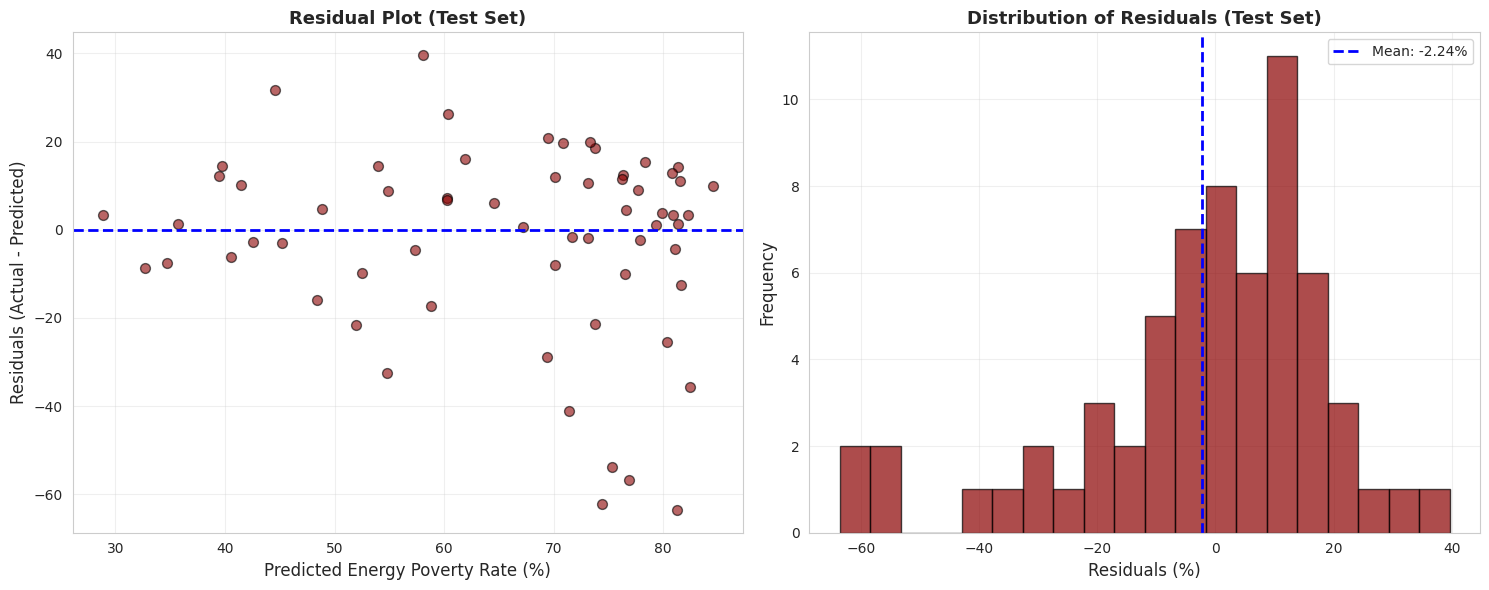

In [17]:
# Residual analysis
residuals_test = y_test - y_test_pred

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Residuals vs Predicted
axes[0].scatter(y_test_pred, residuals_test, alpha=0.6, edgecolor='black', s=50, color='darkred')
axes[0].axhline(y=0, color='blue', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Energy Poverty Rate (%)', fontsize=12)
axes[0].set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
axes[0].set_title('Residual Plot (Test Set)', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)

# Residuals distribution
axes[1].hist(residuals_test, bins=20, edgecolor='black', alpha=0.7, color='darkred')
axes[1].axvline(residuals_test.mean(), color='blue', linestyle='--', linewidth=2,
                label=f'Mean: {residuals_test.mean():.2f}%')
axes[1].set_xlabel('Residuals (%)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Residuals (Test Set)', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Feature Importance Analysis

In [18]:
# Get feature importances
feature_importance = pd.DataFrame({
    'feature': embedding_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🌟 Top 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))


🌟 Top 20 Most Important Features:
feature  importance
    A43    0.078370
    A25    0.065027
    A23    0.046939
    A61    0.046207
    A62    0.043660
    A54    0.036860
    A52    0.034439
    A10    0.033293
    A36    0.031865
    A31    0.030455
    A58    0.024156
    A07    0.023394
    A04    0.020396
    A01    0.018920
    A57    0.017923
    A37    0.016410
    A29    0.015911
    A33    0.014893
    A21    0.014788
    A59    0.014475


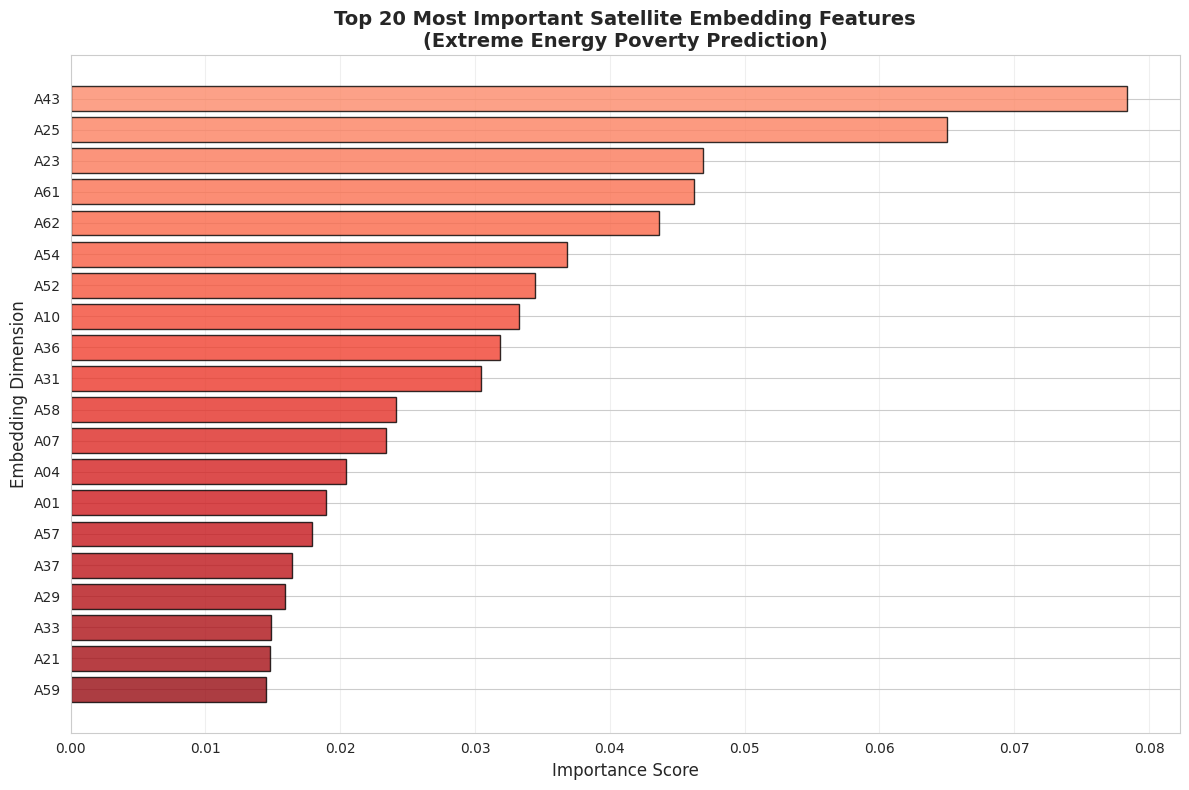

In [19]:
# Visualize top 20 features
top_n = 20
top_features = feature_importance.head(top_n)

plt.figure(figsize=(12, 8))
colors = plt.cm.Reds(np.linspace(0.4, 0.9, top_n))
plt.barh(range(top_n), top_features['importance'].values, color=colors, edgecolor='black', alpha=0.8)
plt.yticks(range(top_n), top_features['feature'].values)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Embedding Dimension', fontsize=12)
plt.title(f'Top {top_n} Most Important Satellite Embedding Features\n(Extreme Energy Poverty Prediction)',
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


📊 Cumulative Importance Analysis:
  Features needed for 80% importance: 36 (56.2%)
  Features needed for 95% importance: 56 (87.5%)

  This means we could reduce dimensionality significantly!


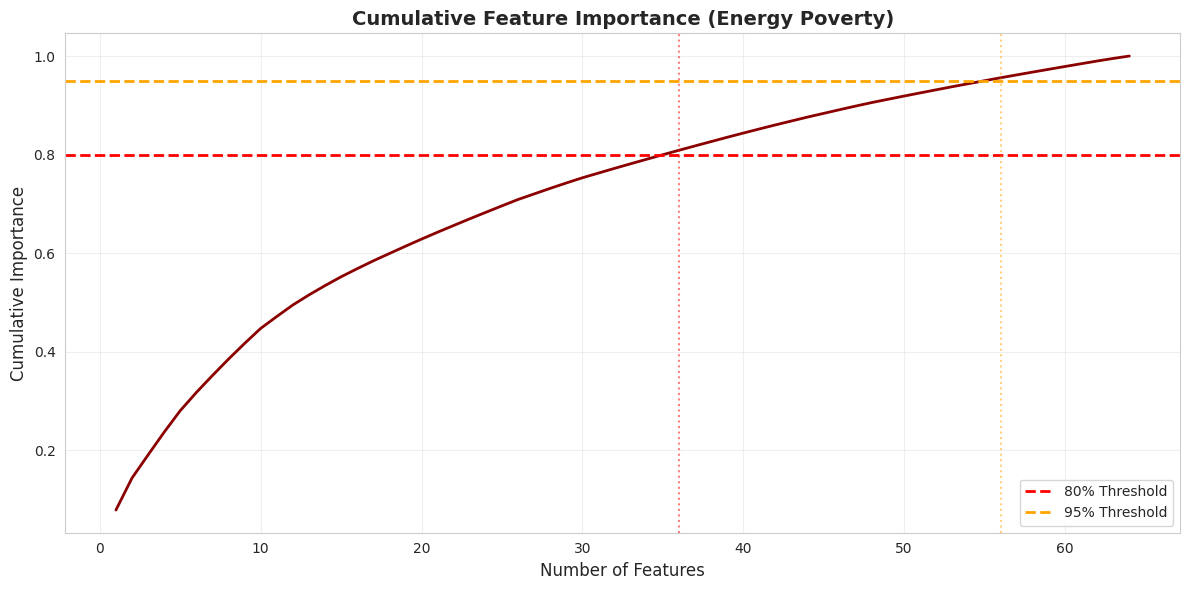

In [20]:
# Cumulative importance
feature_importance['cumulative_importance'] = feature_importance['importance'].cumsum()

# Find number of features needed for 80% and 95% importance
n_features_80 = (feature_importance['cumulative_importance'] <= 0.80).sum() + 1
n_features_95 = (feature_importance['cumulative_importance'] <= 0.95).sum() + 1

print(f"\n📊 Cumulative Importance Analysis:")
print(f"  Features needed for 80% importance: {n_features_80} ({n_features_80/len(embedding_cols)*100:.1f}%)")
print(f"  Features needed for 95% importance: {n_features_95} ({n_features_95/len(embedding_cols)*100:.1f}%)")
print(f"\n  This means we could reduce dimensionality significantly!")

# Plot cumulative importance
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(feature_importance) + 1),
         feature_importance['cumulative_importance'].values,
         linewidth=2, color='darkred')
plt.axhline(y=0.80, color='red', linestyle='--', linewidth=2, label='80% Threshold')
plt.axhline(y=0.95, color='orange', linestyle='--', linewidth=2, label='95% Threshold')
plt.axvline(x=n_features_80, color='red', linestyle=':', alpha=0.5)
plt.axvline(x=n_features_95, color='orange', linestyle=':', alpha=0.5)
plt.xlabel('Number of Features', fontsize=12)
plt.ylabel('Cumulative Importance', fontsize=12)
plt.title('Cumulative Feature Importance (Energy Poverty)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

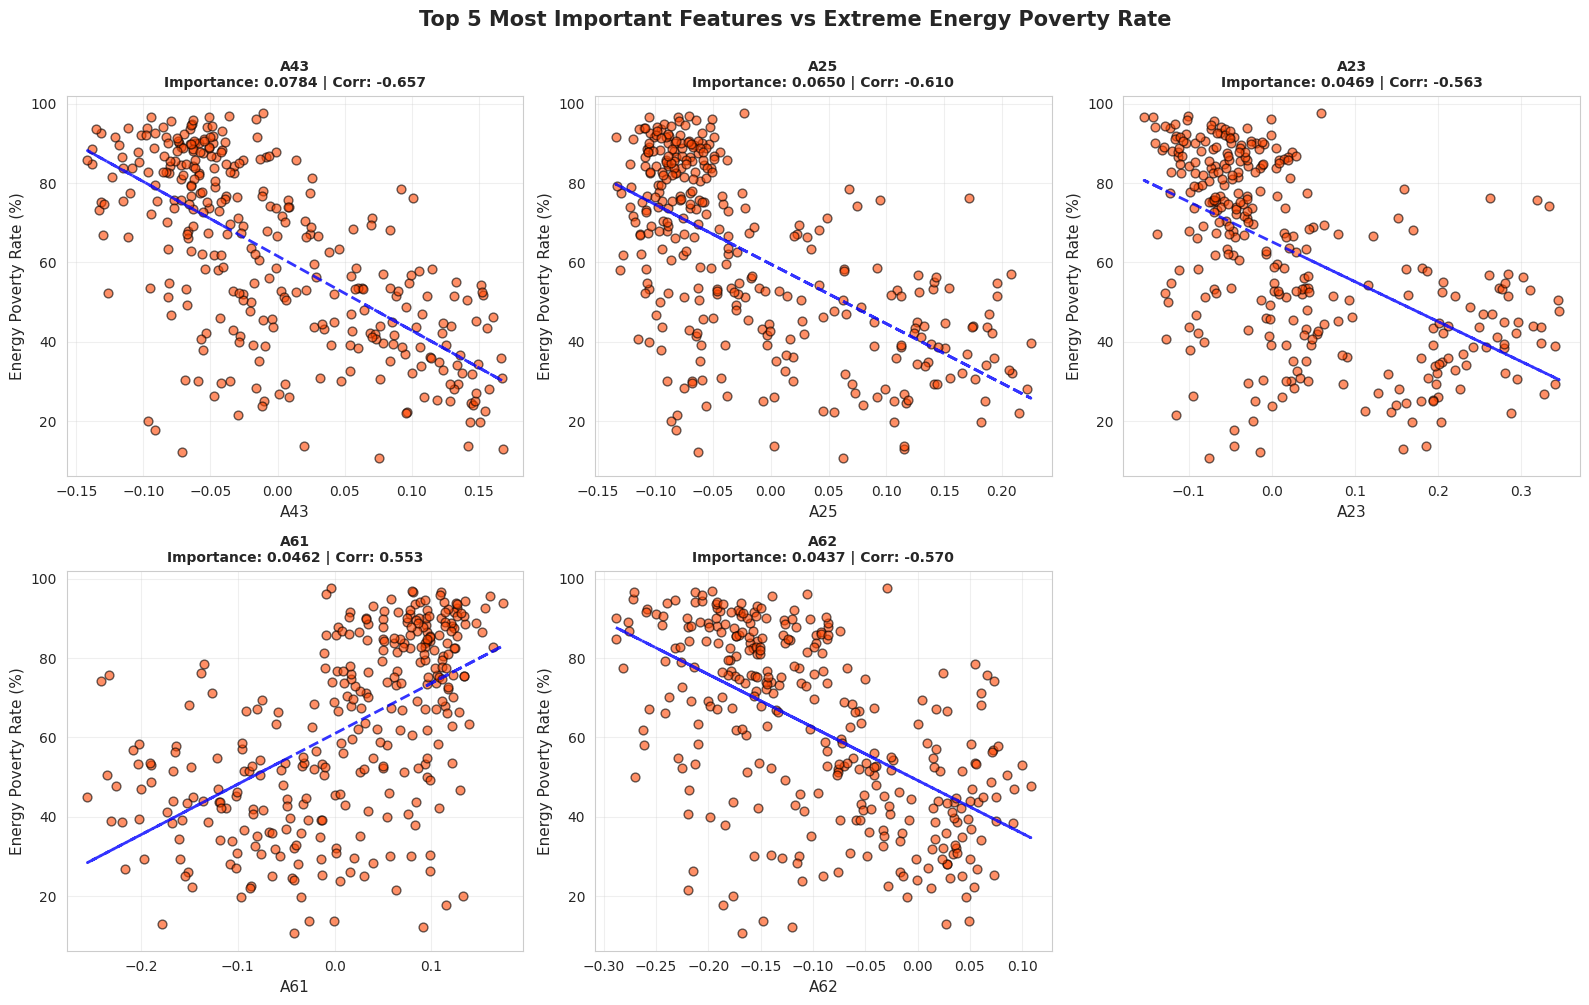

In [21]:
# Analyze relationship between top features and target
top_5_features = feature_importance.head(5)['feature'].values

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_5_features):
    ax = axes[idx]
    ax.scatter(df_clean[feature], df_clean[target_var], alpha=0.6, edgecolor='black', s=40, color='orangered')

    # Add trend line
    z = np.polyfit(df_clean[feature], df_clean[target_var], 1)
    p = np.poly1d(z)
    ax.plot(df_clean[feature], p(df_clean[feature]), "b--", linewidth=2, alpha=0.8)

    # Calculate correlation
    corr = df_clean[[feature, target_var]].corr().iloc[0, 1]

    ax.set_xlabel(f'{feature}', fontsize=11)
    ax.set_ylabel('Energy Poverty Rate (%)', fontsize=11)
    importance_val = feature_importance[feature_importance["feature"]==feature]["importance"].values[0]
    ax.set_title(f'{feature}\nImportance: {importance_val:.4f} | Corr: {corr:.3f}',
                 fontsize=10, fontweight='bold')
    ax.grid(alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[5])

plt.suptitle('Top 5 Most Important Features vs Extreme Energy Poverty Rate', fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 7. Prediction Analysis

In [22]:
# Predict for all municipalities
y_pred_all = rf_model.predict(X)

# Create results dataframe
results_df = df_clean[['asdf_id', 'mun', 'dep', target_var]].copy()
results_df['predicted_eepr'] = y_pred_all
results_df['residual'] = results_df[target_var] - results_df['predicted_eepr']
results_df['abs_error'] = np.abs(results_df['residual'])

print("\n📍 Prediction Summary:")
print(f"  Mean absolute error: {results_df['abs_error'].mean():.2f} percentage points")
print(f"  Median absolute error: {results_df['abs_error'].median():.2f} percentage points")
print(f"  Max absolute error: {results_df['abs_error'].max():.2f} percentage points")


📍 Prediction Summary:
  Mean absolute error: 7.33 percentage points
  Median absolute error: 4.77 percentage points
  Max absolute error: 63.58 percentage points


In [23]:
# Municipalities with largest prediction errors
print("\n🔴 Top 10 Overpredictions (Model predicts MORE poverty than actual):")
overpred = results_df.nsmallest(10, 'residual')[['mun', 'dep', target_var, 'predicted_eepr', 'residual']]
print(overpred.to_string(index=False))

print("\n🔵 Top 10 Underpredictions (Model predicts LESS poverty than actual):")
underpred = results_df.nlargest(10, 'residual')[['mun', 'dep', target_var, 'predicted_eepr', 'residual']]
print(underpred.to_string(index=False))


🔴 Top 10 Overpredictions (Model predicts MORE poverty than actual):
        mun        dep  sdg1_1_eepr  predicted_eepr   residual
Quillacollo Cochabamba    17.700001       81.284668 -63.584667
     La Paz     La Paz    12.100000       74.402897 -62.302897
  Tiquipaya Cochabamba    20.100000       76.915935 -56.815935
      Oruro      Oruro    21.600000       75.323791 -53.723791
     Sacaba Cochabamba    30.299999       71.395396 -41.095397
    Huanuni      Oruro    46.799999       82.453903 -35.653904
Buena Vista Santa Cruz    22.299999       54.774512 -32.474513
     Atocha     Potosí    40.599998       69.380546 -28.780548
      Porco     Potosí    54.799999       80.337692 -25.537693
      Sucre Chuquisaca    23.799999       48.268969 -24.468970

🔵 Top 10 Underpredictions (Model predicts LESS poverty than actual):
          mun        dep  sdg1_1_eepr  predicted_eepr  residual
     Cocapata Cochabamba    97.699997       58.093952 39.606045
    El Puente     Tarija    76.199997   

In [24]:
# Identify extreme cases
print("\n⚠️ Municipalities with HIGHEST Extreme Energy Poverty:")
highest = results_df.nlargest(10, target_var)[['mun', 'dep', target_var, 'predicted_eepr', 'abs_error']]
print(highest.to_string(index=False))

print("\n✅ Municipalities with LOWEST Extreme Energy Poverty:")
lowest = results_df.nsmallest(10, target_var)[['mun', 'dep', target_var, 'predicted_eepr', 'abs_error']]
print(lowest.to_string(index=False))


⚠️ Municipalities with HIGHEST Extreme Energy Poverty:
                mun        dep  sdg1_1_eepr  predicted_eepr  abs_error
           Cocapata Cochabamba    97.699997       58.093952  39.606045
            Callapa     La Paz    97.000000       87.893471   9.106529
     Pampa Aullagas      Oruro    96.699997       90.712427   5.987570
 Yunguyo de Litoral      Oruro    96.599998       88.827752   7.772246
             Poroma Chuquisaca    96.099998       80.265892  15.834106
           Calacoto     La Paz    96.000000       91.156461   4.843539
Nazacara de Pacajes     La Paz    95.599998       81.341218  14.258780
           Carangas      Oruro    94.900002       88.725896   6.174106
           Catacora     La Paz    94.599998       86.997518   7.602480
             Toledo      Oruro    94.500000       84.529704   9.970296

✅ Municipalities with LOWEST Extreme Energy Poverty:
        mun        dep  sdg1_1_eepr  predicted_eepr  abs_error
Colcapirhua Cochabamba    10.600000       24.8

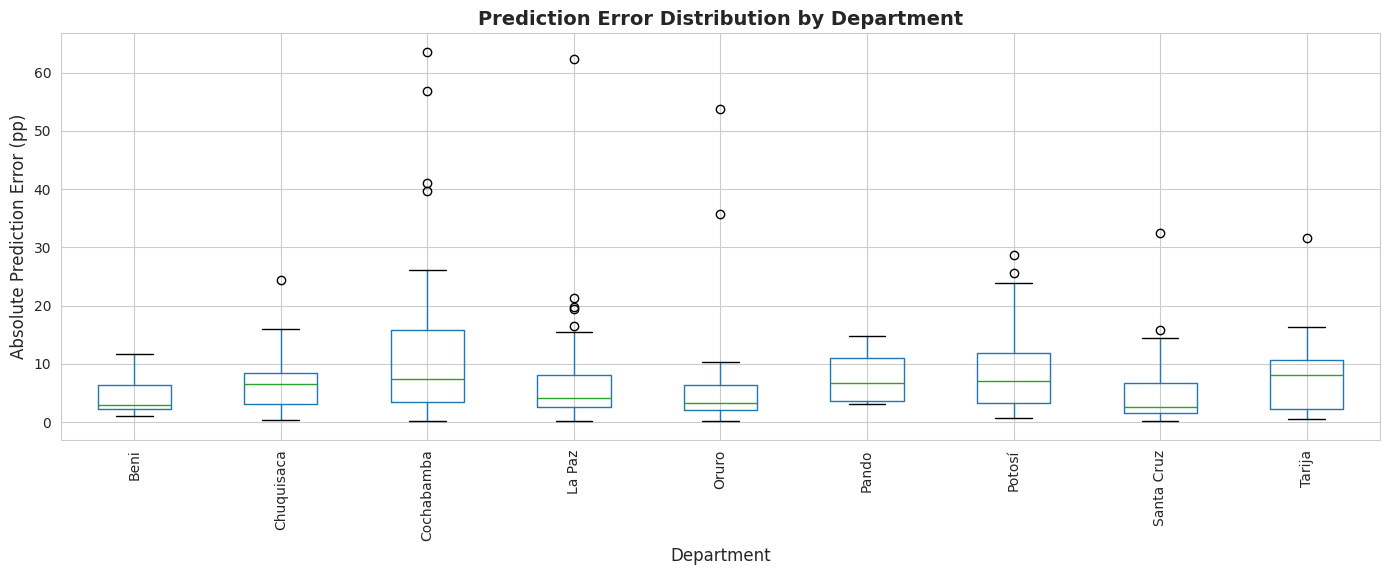

In [25]:
# Visualize error distribution by department
fig, ax = plt.subplots(figsize=(14, 6))
results_df.boxplot(column='abs_error', by='dep', ax=ax, rot=90)
ax.set_xlabel('Department', fontsize=12)
ax.set_ylabel('Absolute Prediction Error (pp)', fontsize=12)
ax.set_title('Prediction Error Distribution by Department', fontsize=14, fontweight='bold')
plt.suptitle('')
plt.tight_layout()
plt.show()

## 8. Spatial Visualization

In [26]:
# Load spatial data for mapping
try:
    import geopandas as gpd

    geojson_url = f"{REPO_URL}/maps/bolivia339geoqueryOpt.geojson"
    print("Loading GeoJSON map...")
    gdf = gpd.read_file(geojson_url)
    gdf['asdf_id'] = gdf['asdf_id'].astype(int)

    # Merge with predictions
    gdf_results = gdf.merge(results_df, on='asdf_id', how='inner')

    print(f"✓ Loaded spatial data for {len(gdf_results)} municipalities")
    spatial_available = True

except ImportError:
    print("⚠ GeoPandas not available. Skipping spatial visualization.")
    print("  Install with: !pip install geopandas")
    spatial_available = False

Loading GeoJSON map...
✓ Loaded spatial data for 315 municipalities


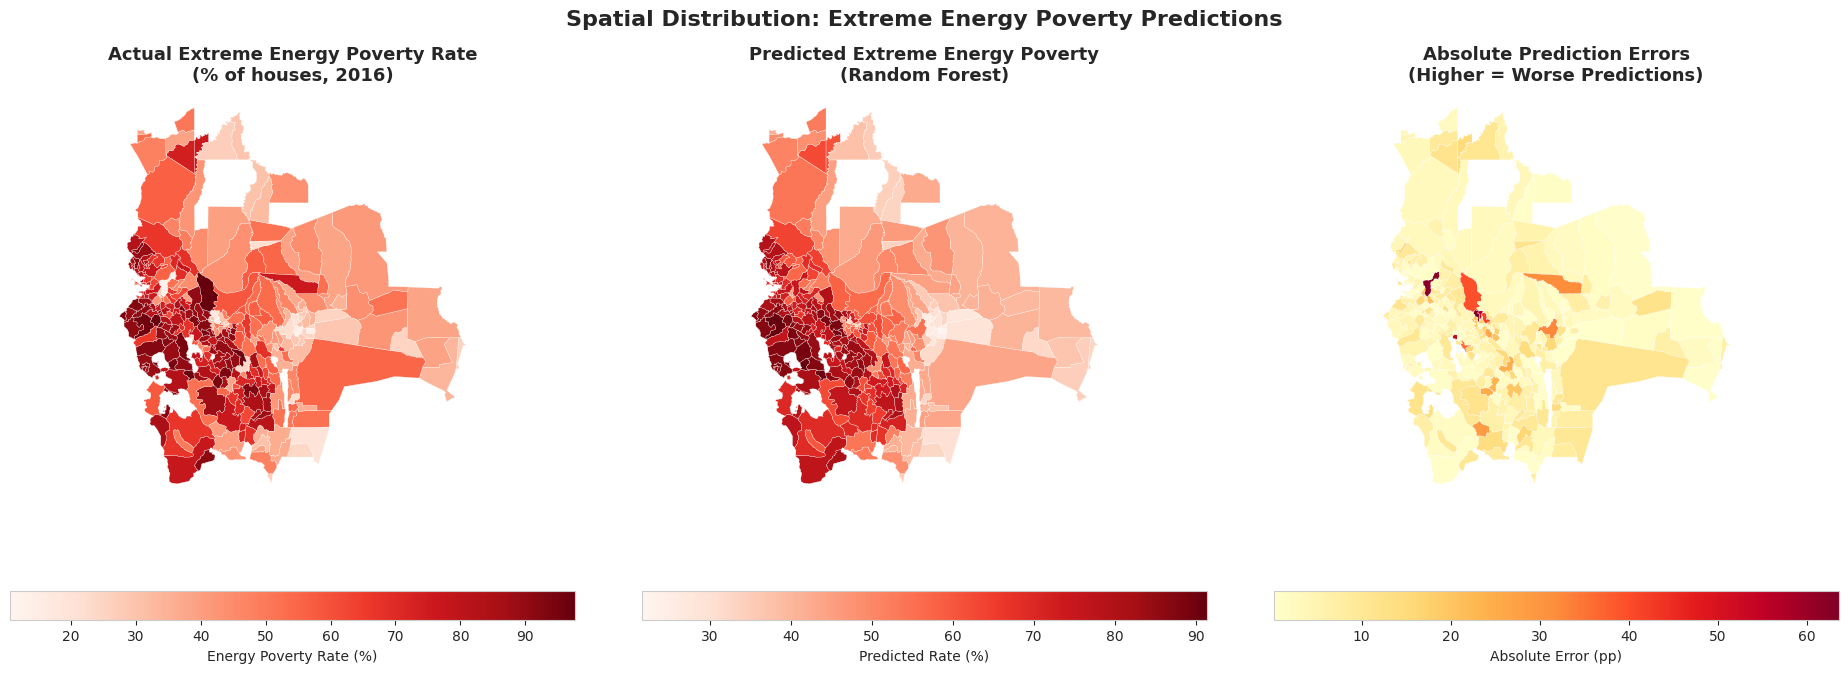

In [27]:
# Create spatial comparison maps
if spatial_available:
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))

    # Actual Energy Poverty
    gdf_results.plot(column=target_var, cmap='Reds', linewidth=0.2,
                     edgecolor='white', legend=True, ax=axes[0],
                     legend_kwds={'label': 'Energy Poverty Rate (%)', 'orientation': 'horizontal', 'shrink': 0.8})
    axes[0].set_title('Actual Extreme Energy Poverty Rate\n(% of houses, 2016)', fontsize=13, fontweight='bold')
    axes[0].set_axis_off()

    # Predicted Energy Poverty
    gdf_results.plot(column='predicted_eepr', cmap='Reds', linewidth=0.2,
                     edgecolor='white', legend=True, ax=axes[1],
                     legend_kwds={'label': 'Predicted Rate (%)', 'orientation': 'horizontal', 'shrink': 0.8})
    axes[1].set_title('Predicted Extreme Energy Poverty\n(Random Forest)', fontsize=13, fontweight='bold')
    axes[1].set_axis_off()

    # Absolute Errors
    gdf_results.plot(column='abs_error', cmap='YlOrRd', linewidth=0.2,
                     edgecolor='white', legend=True, ax=axes[2],
                     legend_kwds={'label': 'Absolute Error (pp)', 'orientation': 'horizontal', 'shrink': 0.8})
    axes[2].set_title('Absolute Prediction Errors\n(Higher = Worse Predictions)',
                      fontsize=13, fontweight='bold')
    axes[2].set_axis_off()

    plt.suptitle('Spatial Distribution: Extreme Energy Poverty Predictions',
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
else:
    print("Spatial visualization skipped (GeoPandas not available)")

## 9. Summary and Insights

In [28]:
print("\n" + "="*80)
print("MODEL SUMMARY: Extreme Energy Poverty Prediction")
print("="*80)

print("\n📊 PERFORMANCE METRICS:")
print(f"  Cross-Validation R² (5-fold): {cv_scores_r2.mean():.4f} (±{cv_scores_r2.std():.4f})")
print(f"  Test Set R²:                  {test_r2:.4f}")
print(f"  Test Set RMSE:                {test_rmse:.4f}%")
print(f"  Test Set MAE:                 {test_mae:.4f}%")

print("\n🌟 FEATURE IMPORTANCE:")
print(f"  Total embedding dimensions:   {len(embedding_cols)}")
print(f"  Features for 80% importance:  {n_features_80} ({n_features_80/len(embedding_cols)*100:.1f}%)")
print(f"  Features for 95% importance:  {n_features_95} ({n_features_95/len(embedding_cols)*100:.1f}%)")
print(f"  Top 5 Features: {', '.join(top_5_features)}")

print("\n📈 DATA CHARACTERISTICS:")
print(f"  Variable: {target_var}")
print(f"  Definition: Extreme energy poverty rate, 2016 (% of houses)")
print(f"  Mean: {y.mean():.1f}%")
print(f"  Range: {y.min():.1f}% to {y.max():.1f}%")

print("\n🎯 KEY INSIGHTS:")
if test_r2 > 0.5:
    print("  ✓ Moderate predictive power: Satellite data captures energy poverty patterns")
elif test_r2 > 0.3:
    print("  ✓ Fair predictive power: Some relationship detected, but additional features needed")
else:
    print("  ⚠ Limited predictive power: Satellite imagery alone is insufficient")

if (train_r2 - test_r2) > 0.3:
    print("  ⚠ Significant overfitting detected: Model memorizes training data")
elif (train_r2 - test_r2) < 0.1:
    print("  ✓ Good generalization: Model performs consistently")
else:
    print("  ⚠ Moderate overfitting: Consider regularization")

print("\n💡 RECOMMENDATIONS:")
print("  1. Add night-time lights data - direct proxy for electricity access")
print("  2. Include urban/rural classification - major cities are overpredicted")
print("  3. Add geographic features - altitude, remoteness, distance to grid")
print("  4. Consider population density - correlates with infrastructure")
print("  5. Use electricity coverage (sdg7_1_ec) as complementary feature")
print("  6. Implement spatial cross-validation to account for autocorrelation")

print("\n" + "="*80)


MODEL SUMMARY: Extreme Energy Poverty Prediction

📊 PERFORMANCE METRICS:
  Cross-Validation R² (5-fold): 0.5704 (±0.0823)
  Test Set R²:                  0.2216
  Test Set RMSE:                21.5127%
  Test Set MAE:                 15.5189%

🌟 FEATURE IMPORTANCE:
  Total embedding dimensions:   64
  Features for 80% importance:  36 (56.2%)
  Features for 95% importance:  56 (87.5%)
  Top 5 Features: A43, A25, A23, A61, A62

📈 DATA CHARACTERISTICS:
  Variable: sdg1_1_eepr
  Definition: Extreme energy poverty rate, 2016 (% of houses)
  Mean: 62.3%
  Range: 10.6% to 97.7%

🎯 KEY INSIGHTS:
  ⚠ Limited predictive power: Satellite imagery alone is insufficient
  ⚠ Significant overfitting detected: Model memorizes training data

💡 RECOMMENDATIONS:
  1. Add night-time lights data - direct proxy for electricity access
  2. Include urban/rural classification - major cities are overpredicted
  3. Add geographic features - altitude, remoteness, distance to grid
  4. Consider population density 

## 10. Export Results (Optional)

In [29]:
# Uncomment to save results
# results_df.to_csv('extreme_energy_poverty_predictions.csv', index=False)
# feature_importance.to_csv('feature_importance_energy_poverty.csv', index=False)
# print("✓ Results exported successfully")

---

## Conclusion

This notebook demonstrated predicting **extreme energy poverty rate** (`sdg1_1_eepr`) using satellite embeddings:

### Key Findings:
1. ✅ **Direct measurement** is more interpretable than composite indices
2. ✅ Satellite imagery captures **moderate patterns** (R² ≈ 0.22-0.57)
3. ⚠️ **Urban centers systematically overpredicted** - La Paz, Cochabamba, Oruro
4. ⚠️ **Rural extreme poverty underpredicted** - Cocapata, Anzaldo, Poroma
5. ✅ Strong correlation with **unsatisfied basic needs** (0.80) and **electricity coverage** (-0.66)

### Why Predictions Fail:
- Satellite imagery cannot distinguish **urban infrastructure** from rural areas
- Missing **night-time lights** - most direct electricity proxy
- No **spatial context** - distance to grid, roads, urban centers
- **Overfitting** - model memorizes training patterns

### Next Steps:
- Incorporate **night-time lights (NTL)** from `/ntl/` directory
- Add **population density** from `/pop/` directory
- Include **urbanization indicator** (`urbano_2012` variable)
- Combine with **SDG 9 (Infrastructure)** indicators
- Use **spatial cross-validation** instead of random splits

### Citation
Mendez, C., Gonzales, E., Leoni, P., Andersen, L., Peralta, H. (2026). DS4Bolivia: A Data Science Repository to Study GeoSpatial Development in Bolivia [Data set]. GitHub. https://github.com/quarcs-lab/ds4bolivia